In [150]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from stop_words import get_stop_words
from nltk import sent_tokenize, word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.manifold import TSNE
from pprint import pprint as print
from gensim.models.fasttext import FastText

stop_words = get_stop_words('ru')
morph = MorphAnalyzer()

## Загрузим тексты и сохраним в одну переменную

In [30]:
with open('Булгаков_Белая гвардия.txt') as text1, open('Булгаков_Роковые яйца.txt') as text2, open('Булгаков_Театральный роман.txt') as text3:
    bulgakov_texts = text1.read() + text2.read() + text3.read()
    print(bulgakov_texts[:100])

 Михаил Булгаков. Белая гвардия

 ----------------------------------------------------------------


## Пропишем функции для предобработки текста

In [79]:
def normalize_sentence(sentence):
    """
    Нормализация предложения: приведение к нижнему регистру и удаление пунктуации.
    """
    sentence = sentence.lower()  
    sentence = re.sub(r'[^\w\s]', '', sentence) 
    return sentence

def lemmatize_word(word):
    """
    Лемматизация одного слова.
    """
    return morph.parse(word)[0].normal_form

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_corpus = []
    for sentence in sentences:
        normalized_sentence = normalize_sentence(sentence)
        tokens = word_tokenize(normalized_sentence)
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [lemmatize_word(token) for token in tokens]

        tokenized_corpus.append(tokens)

    return tokenized_corpus

In [80]:
bulgakov_corpus = preprocess_text(bulgakov_texts)
print(bulgakov_corpus[:50])

[['михаил', 'булгаков'],
 ['белый', 'гвардия', 'правда', '1989'],
 ['ocr',
  'spellcheck',
  'by',
  'harryfan',
  '25',
  'september',
  '2000',
  'посвящаться',
  'любовь',
  'евгениевич',
  'белозерский',
  'пойти',
  'мелкий',
  'снег',
  'повалить',
  'хлопья'],
 ['ветер', 'завыть', 'сделаться', 'метель'],
 ['один', 'мгновение', 'тёмный', 'небо', 'смешаться', 'снежный', 'море'],
 ['исчезнуть'],
 ['барин', 'закричать', 'ямщик', 'беда', 'буран'],
 ['капитанский',
  'дочка',
  'судить',
  'мёртвый',
  'написать',
  'книга',
  'сообразно',
  'дело',
  'свой',
  'часть',
  'первый',
  '1',
  'большой',
  'страшный',
  'рождество',
  'христов',
  '1918',
  'революция'],
 ['обильный',
  'лето',
  'солнце',
  'зима',
  'снег',
  'высоко',
  'небо',
  'стоять',
  'звезда',
  'звезда',
  'пастушеский',
  'вечерний',
  'венера',
  'красный',
  'дрожать',
  'марс'],
 ['день',
  'мирный',
  'кровавый',
  'год',
  'лететь',
  'стрела',
  'молодой',
  'турбина',
  'заметить',
  'крепкий',
  'мор

In [82]:
len(bulgakov_corpus)

11954

## Почему бы и нет? Обучим фаст текст на предобработанном текстовом файле из трех книг, а также на списке списков (потому что я сначала подумал, что можно прикрепить только файл, а потом оказалось, что аргументом можно подать и переменную со списком)

In [126]:
model = FastText(
    vector_size=100)

# build the vocabulary
model.build_vocab(corpus_file='bulgakov_corpus.txt')

model.train(
    corpus_file='bulgakov_corpus.txt', epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True
)

print(model)

In [121]:
model_tokenized = FastText(vector_size=100)
model_tokenized.build_vocab(corpus_iterable=bulgakov_corpus)
model_tokenized.train(
    corpus_iterable=bulgakov_corpus, epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True
)
print(model_tokenized)

## Сравним, насколько отличаются результаты моделей в зависимости от использованного корпуса - файл или список списков

In [133]:
wv = model.wv
wv_token = model_tokenized.wv
similar_words_token = wv_token.most_similar('мальчик')
similar_words_file = wv.most_similar('мальчик')


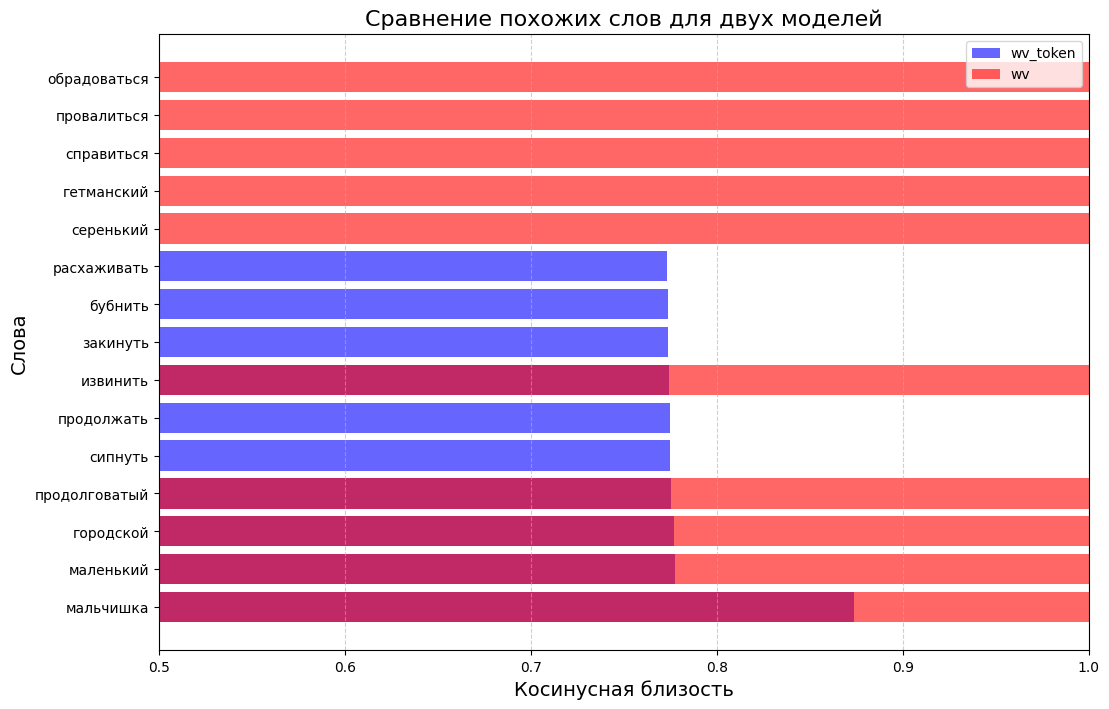

In [134]:
def plot_compare_similar_words(similar_words_1, similar_words_2, label_1, label_2, title):
    words_1 = [word for word, _ in similar_words_1]
    similarities_1 = [sim for _, sim in similar_words_1]

    words_2 = [word for word, _ in similar_words_2]
    similarities_2 = [sim for _, sim in similar_words_2]

    plt.figure(figsize=(12, 8))
    plt.barh(words_1, similarities_1, color='blue', alpha=0.6, label=label_1)
    plt.barh(words_2, similarities_2, color='red', alpha=0.6, label=label_2)
    plt.title(title, fontsize=16)
    plt.xlabel("Косинусная близость", fontsize=14)
    plt.ylabel("Слова", fontsize=14)
    plt.legend()
    plt.xlim(0.5, 1.0)
    plt.grid(True, axis="x", linestyle="--", alpha=0.6)
    plt.show()

plot_compare_similar_words(
    similar_words_token,
    similar_words_file,
    label_1="wv_token",
    label_2="wv",
    title="Сравнение похожих слов для двух моделей"
)

# Посмотрим heatmap

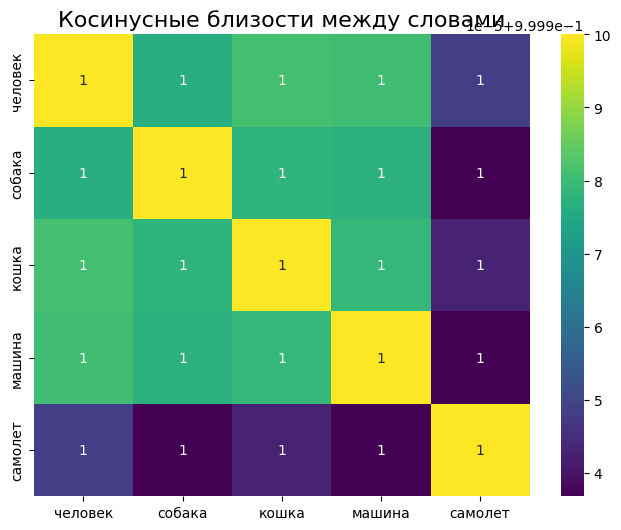

In [145]:
words = ["человек", "собака", "кошка", "машина", "самолет"]

similarity_matrix = np.zeros((len(words), len(words)))
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity_matrix[i, j] = model.wv.similarity(word1, word2)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap="viridis")
plt.title("Косинусные близости между словами", fontsize=16)
plt.show()

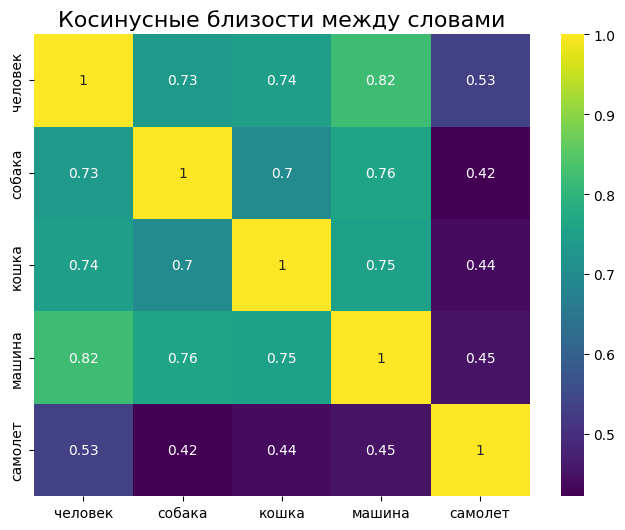

In [137]:
words = ["человек", "собака", "кошка", "машина", "самолет"]

similarity_matrix = np.zeros((len(words), len(words)))
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity_matrix[i, j] = model_tokenized.wv.similarity(word1, word2)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap="viridis")
plt.title("Косинусные близости между словами", fontsize=16)
plt.show()

# Посмотрим на кластеры

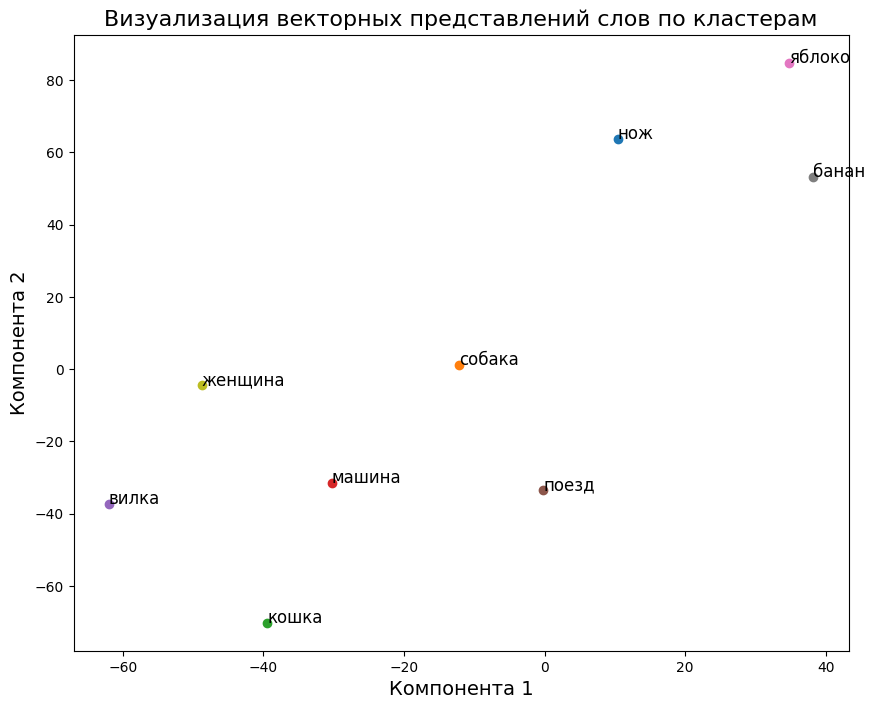

In [143]:
words = ["нож", "собака", "кошка", "машина", "вилка", "поезд", "яблоко", "банан", "женщина"]

word_vectors = [model.wv[word] for word in words]

word_vectors = np.array(word_vectors)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=12)

plt.title("Визуализация векторных представлений слов по кластерам", fontsize=16)
plt.xlabel("Компонента 1", fontsize=14)
plt.ylabel("Компонента 2", fontsize=14)
plt.show()

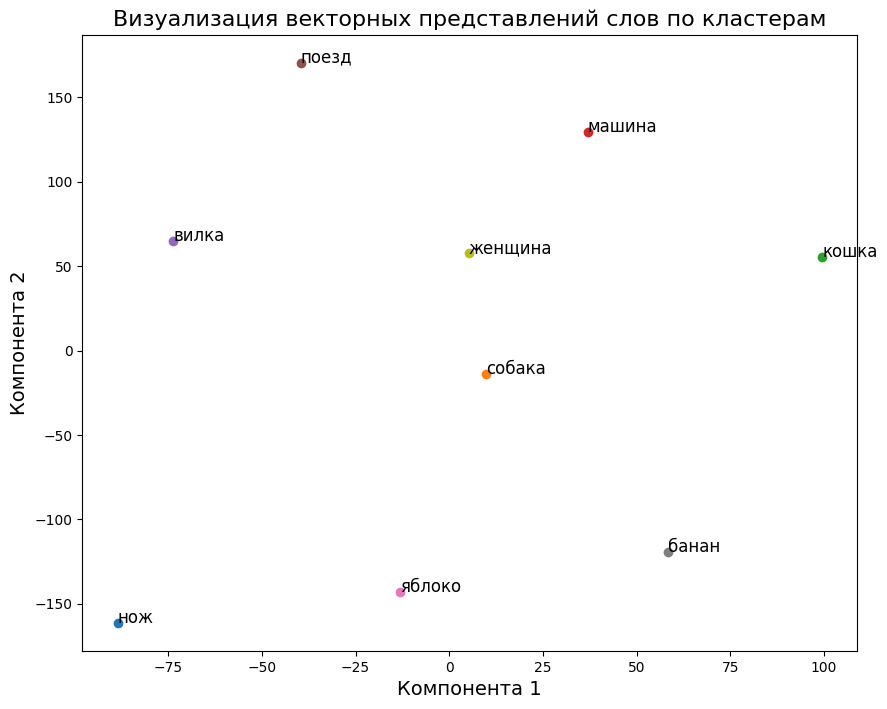

In [144]:
words = ["нож", "собака", "кошка", "машина", "вилка", "поезд", "яблоко", "банан", "женщина"]

word_vectors = [model_tokenized.wv[word] for word in words]

word_vectors = np.array(word_vectors)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)  
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=12)

plt.title("Визуализация векторных представлений слов по кластерам", fontsize=16)
plt.xlabel("Компонента 1", fontsize=14)
plt.ylabel("Компонента 2", fontsize=14)
plt.show()

# по всей видимости, размера корпуса недостаточно, получилось около 80 тысяч токенов. Некоторые сравнения более-менее близки к реальности, другие же очень от нее далеки. В любом случае, для хорошей работы нужен корпус побольше, но было интересно попробовать для начала, учитывая, насколько легко и быстро можно обучить такую модель